### Loading the dataset containing the export data alongside with the nodal attribute available on each country

In [224]:
edges = read.csv('../datasets/wits/simulated/edgelist.csv')
nodes = read.csv('../datasets/wits/simulated/nodelist.csv')

In [225]:
simulated_edges_base_path = '../datasets/wits/simulated/simulations/'
simulated_edges_data = list.files(path = simulated_edges_base_path)

In [226]:
for (i in 1:length(simulated_edges_data)) {
    simulated_edges_data[i] = paste(simulated_edges_base_path, simulated_edges_data[i], sep = '')
}

In [227]:
simulated_edges = lapply(simulated_edges_data, read.csv)

In [228]:
n = dim(nodes)[1]
N = length(simulated_edges)
country_names = nodes$country_iso3
nodes = transform(nodes, landlocked=as.logical(landlocked))

### Importing the library required for doing permutation tests

In [229]:
library(coin)
library(sna)
library(ergm)

In [230]:
head(nodes, 3)

,country_iso3,merchandise_of_gdp,area,population,industry_of_gdp,continent,agriculture_forestry_fishing_of_gdp,life_expectancy,landlocked,colonizer,net_barter_of_trade,inflation_rate,langoff_1,gni_atlas,foreign_direct_investment_inflows,happiness,gdp_us_dollar,gdp_growth,gdp_per_capita
,<chr>,<dbl>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AFG,38.70415,652225,30117411,22.74025,Asia,23.743664,61.553,TRUE,USA,144.7519,11.804186,Persian,16077121256,52173421,0.721,17804292964,0.4263548,591.1628
2,AGO,78.30597,1246700,24220660,56.02651,Africa,5.845681,56.330,FALSE,PRT,244.3292,13.482468,Portuguese,82606027251,-3023770966,0.708,111789686464,3.4719763,4615.4682
3,ALB,56.86241,28748,2905195,24.48441,Europe,18.226765,76.914,FALSE,NONE,94.3372,3.429123,Albanian,12803715190,1048706682,0.568,12890765324,2.5453218,4437.1429


In [231]:
head(edges, 3)

,source,target,weight
,<chr>,<chr>,<dbl>
1,AFG,TKM,0.189
2,AGO,JPN,1369.367
3,AGO,BEN,1700.981


In [232]:
net = network(edges, directed = TRUE, matrix.type = 'edgelist')
set.vertex.attribute(x = net, attrname = colnames(nodes), value = nodes)
net

 Network attributes:
  vertices = 141 
  directed = TRUE 
  hyper = FALSE 
  loops = FALSE 
  multiple = FALSE 
  bipartite = FALSE 
  total edges= 2874 
    missing edges= 0 
    non-missing edges= 2874 

 Vertex attribute names: 
    agriculture_forestry_fishing_of_gdp area colonizer continent country_iso3 foreign_direct_investment_inflows gdp_growth gdp_per_capita gdp_us_dollar gni_atlas happiness industry_of_gdp inflation_rate landlocked langoff_1 life_expectancy merchandise_of_gdp net_barter_of_trade population vertex.names 

 Edge attribute names not shown 

### Generating the adjacency matrix of the export network and the total Export/Import of all countries

In [233]:
compute_sum_export_import = function(edges, nodes) {
    countries_export_import = data.frame(
        country = c(nodes$country_iso3), 
        exports = matrix(0, nrow =n , ncol = 1),
        imports = matrix(0, nrow =n , ncol = 1)
    )
    for (i in 1:n) {
        countries_export_import[i, 2:3] = c(
            sum(edges$source == countries_export_import$country[i]), 
            sum(edges$target == countries_export_import$country[i])
        )
    }
    nodes$exports = countries_export_import$exports
    nodes$imports = countries_export_import$imports
    
    col_statistic_exports = sum(nodes$exports[nodes$colonizer == 'GBR'])
    col_statistic_imports = sum(nodes$imports[nodes$colonizer == 'GBR'])
    
    return(c(col_statistic_exports, col_statistic_imports))
}

In [234]:
col_observed_statistics = compute_sum_export_import(edges, nodes)
col_observed_statistic_exports = col_observed_statistics[1]
col_observed_statistic_imports = col_observed_statistics[2]

In [235]:
col_permutated_statistic_exports = matrix(0, nrow=N, ncol=1)
col_permutated_statistic_imports = matrix(0, nrow=N, ncol=1)
for (i in 1:N) {
    col_permutated_statistics = compute_sum_export_import(simulated_edges[[i]], nodes)
    col_permutated_statistic_exports[i,] = col_permutated_statistics[1]
    col_permutated_statistic_imports[i,] = col_permutated_statistics[2]
}


[1] 0

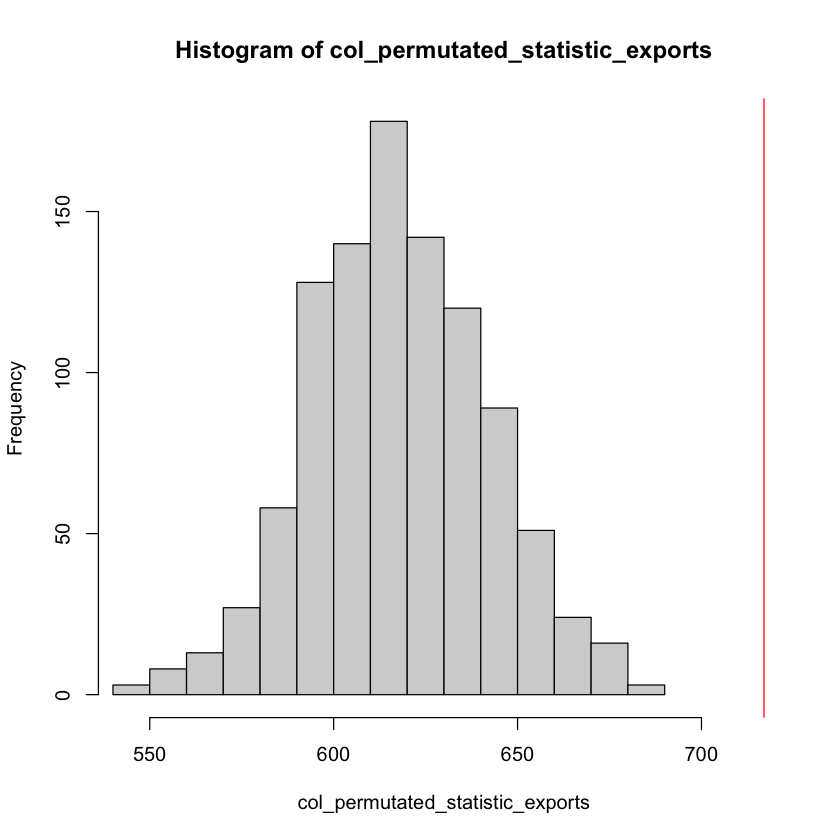

In [236]:
par(bg = 'white')
hist(
    col_permutated_statistic_exports, 
    xlim = c(
        min(min(col_permutated_statistic_exports), col_observed_statistic_exports), 
        max(max(col_permutated_statistic_exports), col_observed_statistic_exports))
)
abline(v=col_observed_statistic_exports, col='red')
mean(col_permutated_statistic_exports > col_observed_statistic_exports)

[1] 0.011

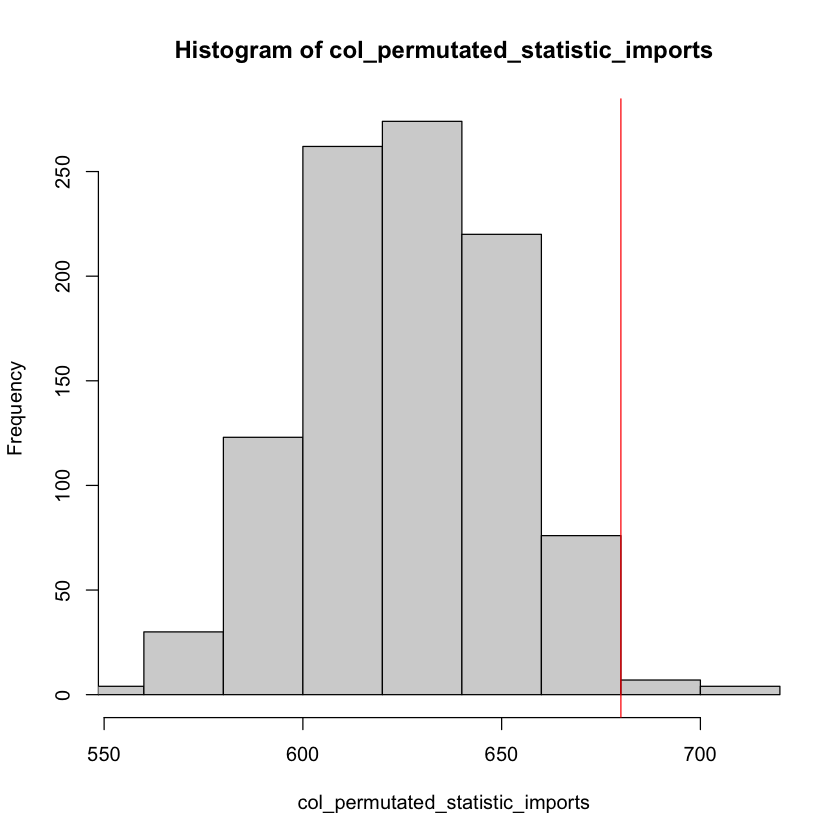

In [237]:
par(bg = 'white')
hist(
    col_permutated_statistic_imports, 
    xlim = c(
        min(min(col_permutated_statistic_imports), col_observed_statistic_imports), 
        max(max(col_permutated_statistic_imports), col_observed_statistic_imports))
)
abline(v=col_observed_statistic_imports, col='red')
mean(col_permutated_statistic_imports > col_observed_statistic_imports)

### Examining the effect of homophily on the network of trades

In [238]:
count_homophily = function(edges, nodes, attrs, ...) {
    count = 0
    for (i in 1:dim(edges)[1]) {
        if (attrs[nodes$country_iso3 == edges$source[i]] == attrs[nodes$country_iso3 == edges$target[i]]) {
            count = count + 1
        }
    }
    return(count)
}

In [242]:
execute_permutation_test = function(edges, nodes, func, attrs, attr, ...) {
    params = list(...)
    observed_statistic = func(edges, nodes, attrs, params)
    
#    computing the specified statistic for all the permutated networks
    permutated_statistics = matrix(0, nrow = N, ncol = 1)
    for (i in 1:N) {
        permutated_statistics[i] = func(simulated_edges[[i]], nodes, attrs, params)
    }
    
    p_value = mean(permutated_statistics < observed_statistic)
    if (p_value > .5) {
        p_value = 1 - p_value
    }
    
    print(paste(attr, ',', p_value))
    pdf(paste('../results/', attr, 'ergm.pdf'))
    par(bg = 'white')
    hist(
        permutated_statistics, 
        xlim=c(min(min(permutated_statistics), observed_statistic), max(max(permutated_statistics), observed_statistic)), 
        main = paste('Comparison of the observed statistic and \npermutated ones with respect to \n', attr, 'with p-value: ', p_value)
    )
    abline(v=observed_statistic, col='red')
    
    dev.off()
}

In [243]:
categories = !unlist(lapply(nodes, FUN = is.numeric))
categories[attr(categories, 'names') == 'country_iso3'] = FALSE
categories = colnames(nodes[, categories])

In [244]:
for (col in categories) {
    execute_permutation_test(edges, nodes, count_homophily, nodes[, col], paste('homophily ', as.character(col)))
}

[1] "homophily  continent , 0.473"
[1] "homophily  landlocked , 0.494"
[1] "homophily  colonizer , 0.486"
[1] "homophily  langoff_1 , 0.462"


### Examining the effect of closeness

In [245]:
compute_nodecov = function(edges, nodes, attrs, ...) {
#     log transformation parameter
    params = list(...)
    sum = 0
    for (i in 1:dim(edges)[1]) {
        if (as.logical(params[[1]])) {
            sum = sum + log(attrs[nodes$country_iso3 == edges$source[i]] + attrs[nodes$country_iso3 == edges$target[i]])
        } else {
            sum = sum + attrs[nodes$country_iso3 == edges$source[i]] + attrs[nodes$country_iso3 == edges$target[i]]
        }
    }
    return(sum)
}

In [246]:
compute_absdiff = function(edges, nodes, attrs, ...) {
#     log transformation parameter
    params = list(...)
    diff_sum = 0
    for (i in 1:dim(edges)[1]) {
        if (as.logical(params[[1]])) {
            diff_sum = diff_sum + log(1 + abs(attrs[nodes$country_iso3 == edges$source[i]] - attrs[nodes$country_iso3 == edges$target[i]]))
        } else {
            diff_sum = diff_sum + abs(attrs[nodes$country_iso3 == edges$source[i]] - attrs[nodes$country_iso3 == edges$target[i]])
        }
    }
    return(diff_sum)
}

In [247]:
nums <- unlist(lapply(nodes, is.numeric))
nums = colnames(nodes[, nums])

In [248]:
for (col in nums) {
    execute_permutation_test(edges, nodes, compute_nodecov, nodes[, col], paste('nodecov ', as.character(col)), FALSE)
    execute_permutation_test(edges, nodes, compute_absdiff, nodes[, col], paste('absdiff ', as.character(col)), FALSE)
}

[1] "nodecov  merchandise_of_gdp , 0.435"
[1] "absdiff  merchandise_of_gdp , 0.387"
[1] "nodecov  area , 0.011"
[1] "absdiff  area , 0.015"
[1] "nodecov  population , 0"
[1] "absdiff  population , 0"
[1] "nodecov  industry_of_gdp , 0.497"
[1] "absdiff  industry_of_gdp , 0.058"
[1] "nodecov  agriculture_forestry_fishing_of_gdp , 0.441"
[1] "absdiff  agriculture_forestry_fishing_of_gdp , 0.0629999999999999"
[1] "nodecov  life_expectancy , 0.465"
[1] "absdiff  life_expectancy , 0.13"
[1] "nodecov  net_barter_of_trade , 0.483"
[1] "absdiff  net_barter_of_trade , 0.195"
[1] "nodecov  inflation_rate , 0.465"
[1] "absdiff  inflation_rate , 0.468"
[1] "nodecov  gni_atlas , 0.008"
[1] "absdiff  gni_atlas , 0.026"
[1] "nodecov  foreign_direct_investment_inflows , 0.485"
[1] "absdiff  foreign_direct_investment_inflows , 0.21"
[1] "nodecov  happiness , 0.46"
[1] "absdiff  happiness , 0.476"
[1] "nodecov  gdp_us_dollar , 0.009"
[1] "absdiff  gdp_us_dollar , 0.046"
[1] "nodecov  gdp_growth , 0.469"


### Transform numerical data to categorical and do homophily test

In [249]:
for (col in nums) {
    values = nodes[, col]
    breaks <- c(quantile(values)[1] - 1, quantile(values)[2], quantile(values)[4], quantile(values)[5] + 1)
    tags <- c("Low", "Medium", "High")
    execute_permutation_test(edges, nodes, count_homophily, cut(values, breaks = breaks, labels = tags), paste('homophily ', as.character(col)))
}

[1] "homophily  merchandise_of_gdp , 0.486"
[1] "homophily  area , 0.247"
[1] "homophily  population , 0.172"
[1] "homophily  industry_of_gdp , 0.432"
[1] "homophily  agriculture_forestry_fishing_of_gdp , 0.086"
[1] "homophily  life_expectancy , 0.123"
[1] "homophily  net_barter_of_trade , 0.211"
[1] "homophily  inflation_rate , 0.026"
[1] "homophily  gni_atlas , 0.011"
[1] "homophily  foreign_direct_investment_inflows , 0.408"
[1] "homophily  happiness , 0.341"
[1] "homophily  gdp_us_dollar , 0.00700000000000001"
[1] "homophily  gdp_growth , 0.082"
[1] "homophily  gdp_per_capita , 0.481"
